In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/home/tm/projects/Open_Close_GNN-1/'])

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] on linux


In [2]:
import numpy as np
from scipy.stats import zscore

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, Dataset
from torch.optim import lr_scheduler


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split

from tqdm import trange
from tqdm.notebook import tqdm

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

In [3]:
from model.utils import device, train
from augmentation.train_loop import *
from augmentation.data_preparation import *


In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
closed_ihb = np.load('/home/tm/projects/OpenCloseProject/notebooks/closed_ihb.npy')
opened_ihb = np.load('/home/tm/projects/OpenCloseProject/notebooks/opened_ihb.npy')

#closed_ch = np.load("/home/tm/projects/OpenCloseProject/notebooks/closed_china.npy")
#opened_ch = np.load("/home/tm/projects/OpenCloseProject/notebooks/opened_china.npy")

#closed = np.concatenate([closed_ch[:, 120:, :], closed_ihb[:, :, :421]])
#opened = np.concatenate([opened_ch[:, 120:, :], opened_ihb[:, :, :421]])

closed = zscore(closed_ihb)
opened = zscore(opened_ihb)

closed = torch.tensor(closed, dtype=torch.float)
opened = torch.tensor(opened, dtype=torch.float)

closed.shape, opened.shape 

(torch.Size([84, 120, 423]), torch.Size([84, 120, 423]))

In [5]:
# отложенная выборка для теста

global_test_idx = np.random.choice(range(84), 4)
glodal_train_idx = np.setdiff1d(range(84), global_test_idx)

train_closed = closed[glodal_train_idx].clone()
train_opened = opened[glodal_train_idx].clone()

concat = torch.cat([train_closed, train_opened])

In [5]:
abide = np.load('/home/tm/projects/OpenCloseProject/abide_data/train_abide.npy')
abide = zscore(abide)
abide = torch.tensor(abide, dtype=torch.float)
abide.shape

torch.Size([500, 120, 423])

# augmentations

## pos encoding


попытка добавить больше фичей в трансформер, лучше не стало, но можно попробовать еще

In [5]:
import positional_encodings

from positional_encodings.torch_encodings import PositionalEncoding1D

p_enc_1d_model = PositionalEncoding1D(60)

In [148]:
a = p_enc_1d_model(closed)

In [149]:
a.shape

torch.Size([84, 120, 60])

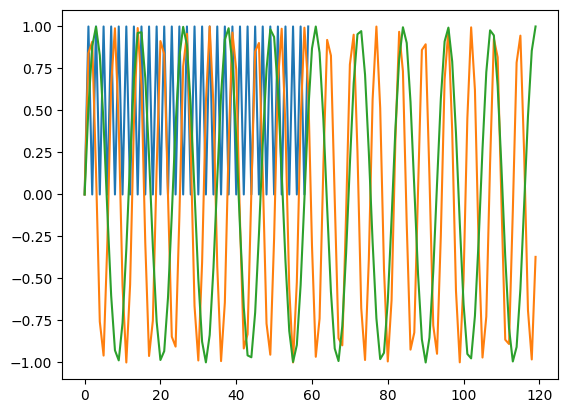

In [151]:
plt.plot(a[0, 0, :])
plt.plot(a[0, :, 0])
plt.plot(a[0, :, 4])

## transformer

In [86]:
# предсказание 1 точки по 20 предыдущим

context, predict = 20, 1
transformer_dataset = transformer_data(concat, context, predict)

batch_size = 64
transformer_train_loader = DataLoader(transformer_dataset, batch_size=batch_size)

In [87]:
lags_sequence = [1, 2, 3, 4, 5, 6, 7]
configuration = TimeSeriesTransformerConfig(prediction_length=predict,
                                            context_length=context - len(lags_sequence),
                                            input_size=423,
                                            num_time_features=1,
                                            lags_sequence=lags_sequence,
                                            num_parallel_samples=1,
                                            scaling='std',
                                            )

aug_model = TimeSeriesTransformerForPrediction(configuration)
aug_model.to(device())

optimizer = torch.optim.AdamW(aug_model.parameters(), lr=1e-3, betas=(0.7, 0.8), weight_decay=0.9)

In [ ]:
epochs = 100
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//2, gamma=10, last_epoch=-1) 

aug_history = train_aug(aug_model, epochs, transformer_train_loader, transformer_train_loader,
                        optimizer=optimizer, transformer=True, save_best=False, scheduler=None, criterion=None,
                        path_to_save='/home/tm/projects/Open_Close_GNN-1/aug/files/aug_trans_model_tl.pt')

In [96]:
augments_per_sample = 1

aug_closed = generate_data(train_closed, aug_model, 
                           context=context, predict=predict,
                           augments_per_sample=augments_per_sample)



100%|██████████| 80/80 [00:31<00:00,  2.53it/s]


In [97]:
aug_opened = generate_data(train_opened, aug_model, 
                           context=context, predict=predict,
                           augments_per_sample=augments_per_sample)

100%|██████████| 80/80 [00:31<00:00,  2.54it/s]


-0.18153451772669338


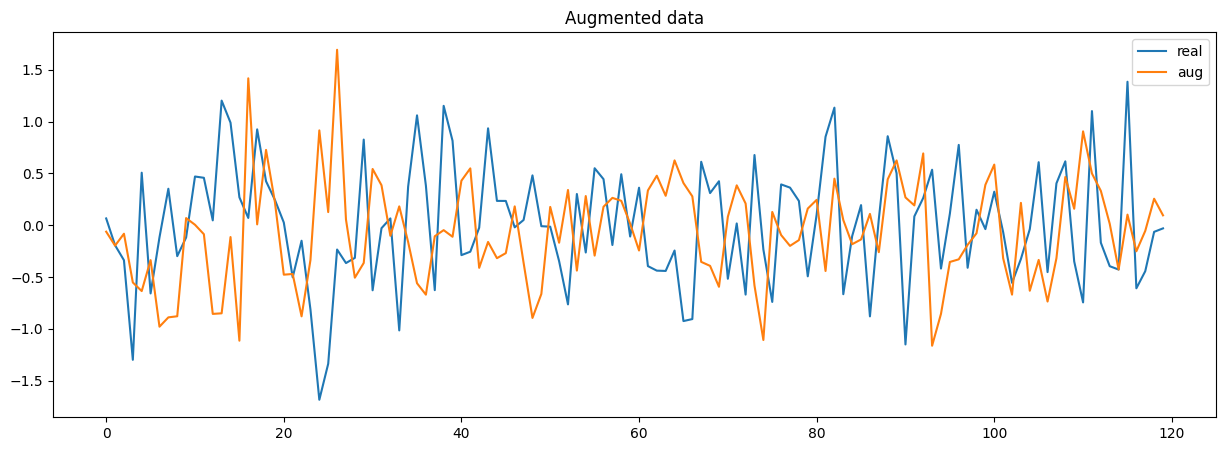

In [90]:
def plot_aug(real, aug, sub, net):
    print(np.corrcoef(aug[sub][:, net], real[sub][:, net])[0, 1])
    plt.figure(figsize=(15, 5))
    plt.plot(real[sub][:, net], label='real')
    plt.plot(aug[sub][:, net], label='aug')
    plt.legend()
    plt.title(f'Augmented data');




plot_aug(opened, aug_opened, sub=65, net=1)

-0.06270069592466525


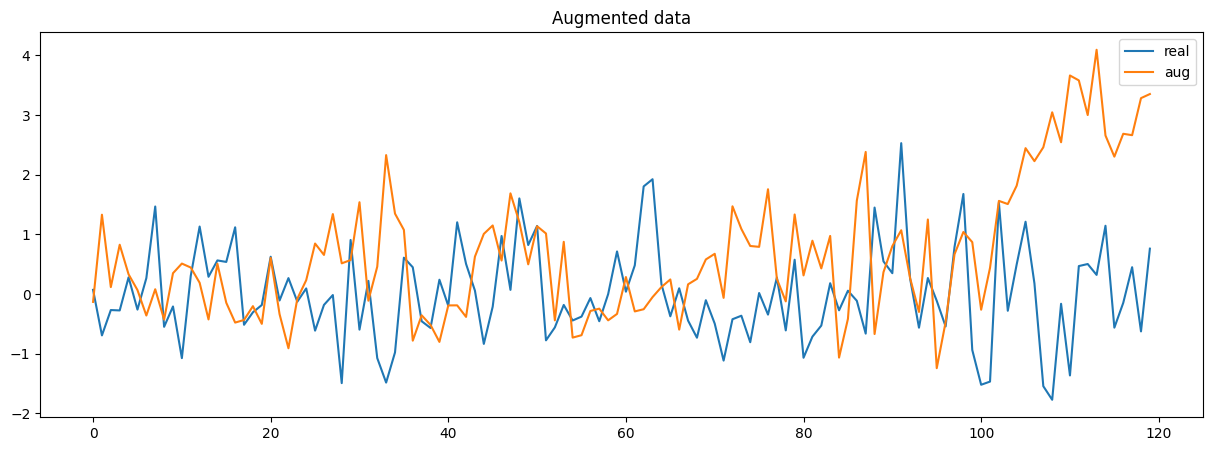

In [91]:
plot_aug(closed, aug_closed, sub=5, net=1)

## lstm

In [115]:
class LSTMGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

In [116]:
# lstm генерирует сразу всю серию для каждого роя

model = LSTMGenerator(423, 32, 2, 423).to(device())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [117]:
lstm_dataset = TensorDataset(concat.to(device()), concat.to(device()))

val_idx = np.random.choice(np.arange(len(train_opened)), 10) 
train_idx = np.setdiff1d(np.arange(len(train_opened)), val_idx)

batch_size = 64
lstm_train_loader = DataLoader(lstm_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
lstm_val_loader = DataLoader(lstm_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx))

In [ ]:
h = train_aug(model, 100, lstm_train_loader, lstm_val_loader, criterion, optimizer)

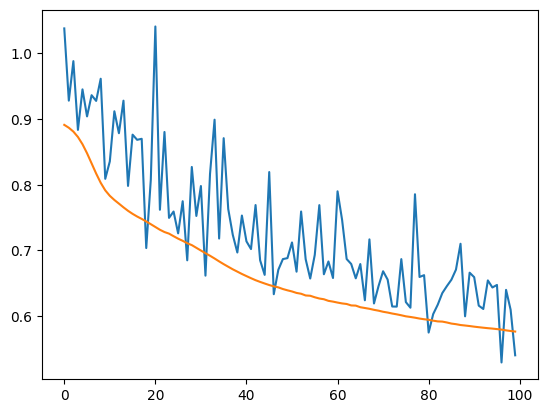

In [119]:
t, v = zip(*h)

plt.plot(t)
plt.plot(v)

In [120]:
generated_series_cl = []
model.eval()
with torch.no_grad():
    for i in train_closed:
        sample_input = i.to(device()).unsqueeze(0)
        generated_series_cl.append(model(sample_input).squeeze(0).cpu().numpy())

In [121]:
generated_series_op = []
model.eval()
with torch.no_grad():
    for i in train_opened:
        sample_input = i.to(device()).unsqueeze(0)
        generated_series_op.append(model(sample_input).squeeze(0).cpu().numpy())

0.7445746549650675


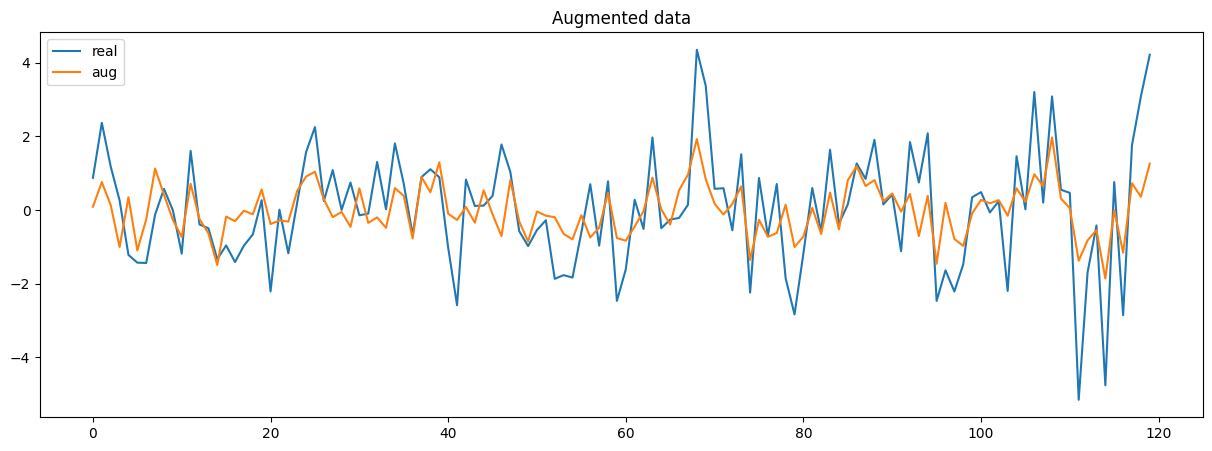

In [122]:
plot_aug(train_closed, generated_series_cl, 1, 8)

In [123]:
# генерация серий по отложенной выборке

generated_series_test = []
model.eval()
with torch.no_grad():
    for i in opened[global_test_idx]:
        sample_input = i.to(device()).unsqueeze(0)
        generated_series_test.append(model(sample_input).squeeze(0).cpu().numpy())

0.49960857055299185


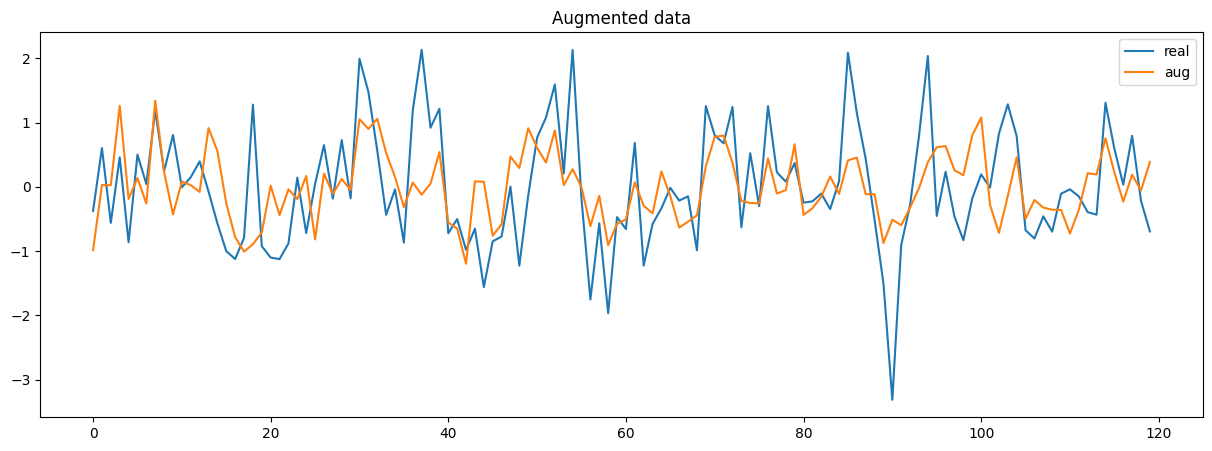

In [124]:
plot_aug(opened[global_test_idx], generated_series_test, 1, 8)

In [138]:
gen_cl = np.concatenate([train_closed.numpy(), generated_series_cl])
gen_op = np.concatenate([train_opened.numpy(), generated_series_op])

## fc

In [139]:
from nilearn.connectome import ConnectivityMeasure

def fc_calc(data):
    con = ConnectivityMeasure(kind='correlation', standardize=False)
    fc_cl = con.fit_transform(data)
    for i in fc_cl:
        np.fill_diagonal(i, 0)
    return fc_cl


In [140]:
fc_cl = fc_calc(gen_cl)
fc_op = fc_calc(gen_op)

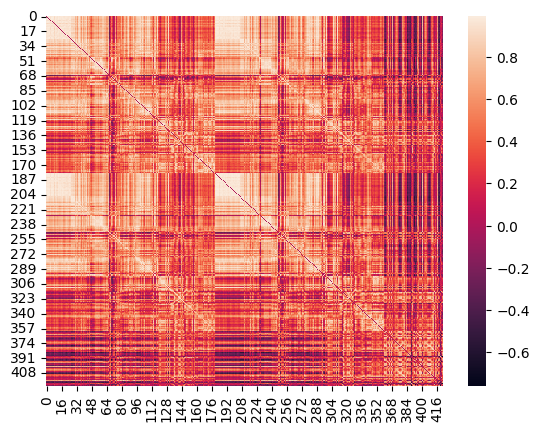

In [153]:
from seaborn import heatmap

heatmap(fc_cl[100]);

# model training

In [141]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from seaborn import heatmap
from sklearn.model_selection import GroupKFold
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm

from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
from model.utils import device, eval_epoch, train, train_epoch, load_data_and_groups

import pickle

In [142]:
full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=5) # k degree

Processing...
Done!


In [143]:
fc_test_op = fc_calc(opened[global_test_idx].numpy())
fc_test_cl = fc_calc(closed[global_test_idx].numpy())

global_test_dataset = OpenCloseDataset(datafolder='/home/tm/projects/Open_Close_GNN-1/aug/test_data', # dir where the processed files will be stored
                                open_file=fc_test_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_test_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

global_test_loader = DataLoader(global_test_dataset, batch_size=len(global_test_dataset), shuffle=False)

Processing...
Done!


In [145]:
labels = [full_dataset[i].y for i in range(len(full_dataset))]

# группы одинаковые для состояний
# в зависимости от того, как конкатенируются сгенерированные данные,
# формируются эти группы
# у меня они конкатенируются [open, open_gen, close, close_gen]

groups = np.concatenate([
            np.arange(train_opened.shape[0], dtype=int), 
            np.arange(train_opened.shape[0], dtype=int), 
            np.arange(train_closed.shape[0], dtype=int),
            np.arange(train_closed.shape[0], dtype=int),
            ])

gkf = GroupKFold()
train_index, val_test_index = next(iter(gkf.split(labels, groups=groups)))

In [146]:
train_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(train_index))
val_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(val_test_index))

In [147]:
model = GCN(full_dataset.num_features, channels=[128, 32], dropout=0.2).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=2)
loss = torch.nn.CrossEntropyLoss()
epochs = 40
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//2, gamma=0.1, last_epoch=-1)
sum(p.numel() for p in model.parameters())

58722

In [ ]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=scheduler, save_best=False, path_to_save='..whatever.pt')

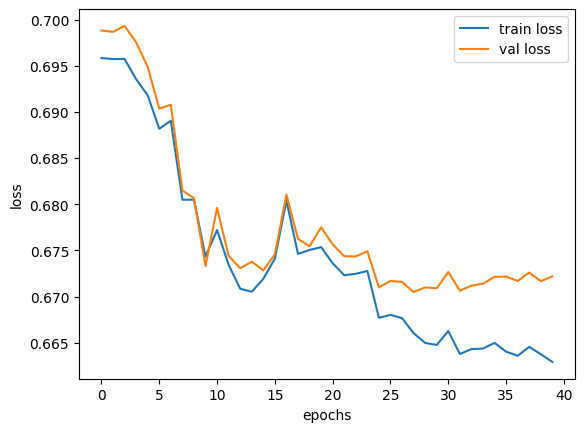

In [149]:
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

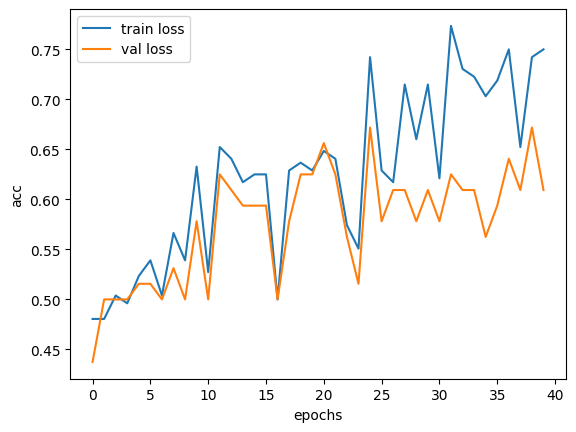

In [150]:
plt.plot(train_acc, label='train loss')
plt.plot(test_acc, label='val loss')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend();

In [152]:
eval_epoch(global_test_loader, model, loss)

(0.6925976276397705, 0.375, 0.42857143, 0.75, 0.54545456)

# см

In [79]:
def cv(n_epochs, lr, dp, crossval_dataset, groups, labels, test_loader):
    skf = GroupKFold(n_splits=50)
    eval_metrics = np.zeros((skf.n_splits, 3))
    #labels = torch.Tensor([i[1] for i in crossval_dataset])

    for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, groups=groups))):
        best_val_loss = 1000
        torch.cuda.empty_cache()
        model = GCN(full_dataset.num_features, channels=[128, 32], dropout=dp).to(device())
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)
        criterion = torch.nn.CrossEntropyLoss()
        #criterion = nn.BCELoss()
        scheduler = lr_scheduler.StepLR(optimizer, step_size=n_epochs//2, gamma=0.1, last_epoch=-1)

        train_loader_cv = DataLoader(crossval_dataset, batch_size=32, shuffle=True, sampler=SubsetRandomSampler(train_idx))
        test_loader_cv = DataLoader(crossval_dataset, batch_size=32, shuffle=True, sampler=SubsetRandomSampler(test_idx))
        min_v_loss = np.inf
        print('==========', n_fold, '==========')
        acc = []
        for epoch in range(n_epochs):
            train_epoch(train_loader_cv, model, criterion, optimizer)
            train_loss, train_acc, _, _, _ = eval_epoch(train_loader_cv, model, criterion)
            val_loss, test_acc, _, _, _ = eval_epoch(test_loader_cv, model, criterion)
            
            #
            #scheduler.step()
            if epoch % 5 == 0:
                print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f},',
                      f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

            acc.append(test_acc)
            
            if min_v_loss > val_loss:
                min_v_loss = val_loss
                best_test_acc = test_acc
            
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '../best_cv_loss.pt')

        model.load_state_dict(torch.load('../best_cv_loss.pt', map_location=device()))
        real_test_loss, real_test_acc, _, _, _ = eval_epoch(test_loader, model, criterion)

        eval_metrics[n_fold, 0] = real_test_acc
        eval_metrics[n_fold, 1] = np.mean(acc)
        eval_metrics[n_fold, 2] = np.std(acc)


    return eval_metrics

In [110]:
gen_cl = np.concatenate([train_closed.numpy(), generated_series_cl[:20]])
gen_op = np.concatenate([train_opened.numpy(), generated_series_op[:20]])

fc_op = fc_calc(gen_op)
fc_cl = fc_calc(gen_cl)

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(train_opened.shape[0], dtype=int), 
            np.arange(train_opened.shape[0], dtype=int)[:20], 
            np.arange(train_closed.shape[0], dtype=int),
            np.arange(train_closed.shape[0], dtype=int)[:20]])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_lstm_84 = cv(20, 0.001, 0.2, full_dataset, groups, labels, global_test_loader)

Processing...
Done!


0it [00:00, ?it/s]

========== 0 ==========
Epoch: 000, Train Loss: 0.6717, Test Loss 0.6578, Train Acc: 0.6562, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.5354, Test Loss 0.4083, Train Acc: 0.6741, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.4585, Test Loss 0.0204, Train Acc: 0.7634, Test Acc: 1.0000
Epoch: 015, Train Loss: 0.0668, Test Loss 0.0406, Train Acc: 1.0000, Test Acc: 1.0000
========== 1 ==========
Epoch: 000, Train Loss: 0.6774, Test Loss 0.7126, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.4784, Test Loss 0.7791, Train Acc: 0.7857, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.2240, Test Loss 0.2462, Train Acc: 0.9330, Test Acc: 1.0000
Epoch: 015, Train Loss: 0.1181, Test Loss 0.1956, Train Acc: 0.9911, Test Acc: 1.0000
========== 2 ==========
Epoch: 000, Train Loss: 0.6757, Test Loss 0.7073, Train Acc: 0.5357, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.4420, Test Loss 0.4299, Train Acc: 0.9152, Test Acc: 1.0000
Epoch: 010, Train Loss: 0.2145, Test Loss 0.1324, Train Acc: 0.9554,

In [100]:
fc_op = fc_calc(train_opened.numpy())
fc_cl = fc_calc(train_closed.numpy())

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(train_opened.shape[0], dtype=int), 
            np.arange(train_closed.shape[0], dtype=int)])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_real = cv(20, 0.001, 0.2, full_dataset, groups, labels, global_test_loader)

Processing...
Done!


0it [00:00, ?it/s]

========== 0 ==========
Epoch: 000, Train Loss: 0.6757, Test Loss 0.6568, Train Acc: 0.5384, Test Acc: 1.0000
Epoch: 005, Train Loss: 0.4983, Test Loss 0.5679, Train Acc: 0.9875, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.1302, Test Loss 0.6143, Train Acc: 1.0000, Test Acc: 0.5000
Epoch: 015, Train Loss: 0.0290, Test Loss 0.7323, Train Acc: 1.0000, Test Acc: 0.5000
========== 1 ==========
Epoch: 000, Train Loss: 0.6834, Test Loss 0.7155, Train Acc: 0.5179, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.5240, Test Loss 0.7866, Train Acc: 0.9429, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.1927, Test Loss 1.0831, Train Acc: 0.9804, Test Acc: 0.5000
Epoch: 015, Train Loss: 0.0395, Test Loss 0.9026, Train Acc: 1.0000, Test Acc: 0.2500
========== 2 ==========
Epoch: 000, Train Loss: 0.6935, Test Loss 0.6811, Train Acc: 0.5027, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.5347, Test Loss 0.6177, Train Acc: 0.8509, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.1805, Test Loss 0.4943, Train Acc: 1.0000,

In [109]:
gen_tr_closed = torch.cat([train_closed, aug_closed[:20]])
gen_tr_opened = torch.cat([train_opened, aug_opened[:20]])

fc_cl = fc_calc(gen_tr_closed.numpy())
fc_op = fc_calc(gen_tr_opened.numpy())

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(train_opened.shape[0], dtype=int), 
            np.arange(train_opened.shape[0], dtype=int)[:20], 
            np.arange(train_closed.shape[0], dtype=int), 
            np.arange(train_closed.shape[0], dtype=int)[:20]])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_trans = cv(20, 0.001, 0.2, full_dataset, groups, labels, global_test_loader)

Processing...
Done!


0it [00:00, ?it/s]

========== 0 ==========
Epoch: 000, Train Loss: 0.6783, Test Loss 0.6832, Train Acc: 0.5312, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.4709, Test Loss 0.6172, Train Acc: 0.8795, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.2367, Test Loss 1.4794, Train Acc: 0.9062, Test Acc: 0.5000
Epoch: 015, Train Loss: 0.0558, Test Loss 0.6900, Train Acc: 1.0000, Test Acc: 0.5000
========== 1 ==========
Epoch: 000, Train Loss: 0.6865, Test Loss 0.6905, Train Acc: 0.5982, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.5302, Test Loss 0.6316, Train Acc: 0.8125, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.1835, Test Loss 0.6330, Train Acc: 0.9955, Test Acc: 0.5000
Epoch: 015, Train Loss: 0.1441, Test Loss 0.5898, Train Acc: 0.9777, Test Acc: 0.5000
========== 2 ==========
Epoch: 000, Train Loss: 0.6776, Test Loss 0.6973, Train Acc: 0.5982, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.4778, Test Loss 0.6516, Train Acc: 0.8929, Test Acc: 0.7500
Epoch: 010, Train Loss: 0.1229, Test Loss 0.8409, Train Acc: 0.9955,

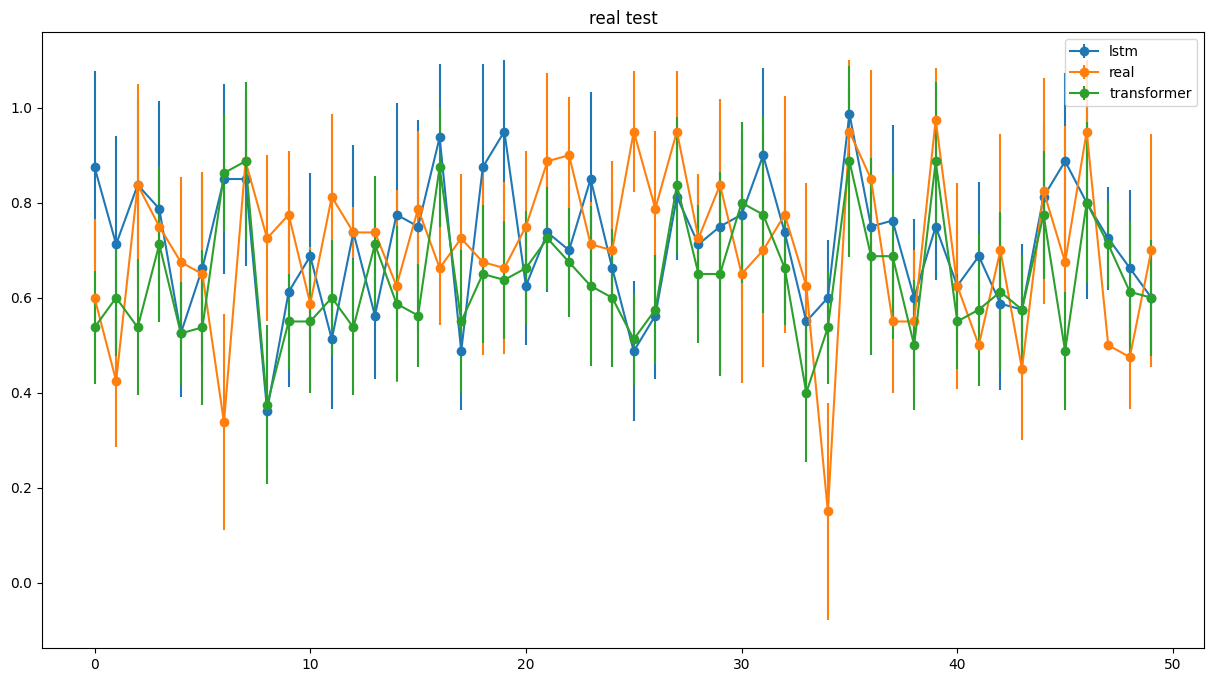

In [111]:
plt.figure(figsize=(15, 8))
plt.errorbar(range(50), eval_metrics_lstm_84[:, 1], yerr=eval_metrics_lstm_84[:, 2], fmt='-o', label='lstm')
plt.errorbar(range(50), eval_metrics_real[:, 1], yerr=eval_metrics_real[:, 2], fmt='-o', label='real')
plt.errorbar(range(50), eval_metrics_trans[:, 1], yerr=eval_metrics_trans[:, 2], fmt='-o', label='transformer')
plt.legend()
plt.title('real test');

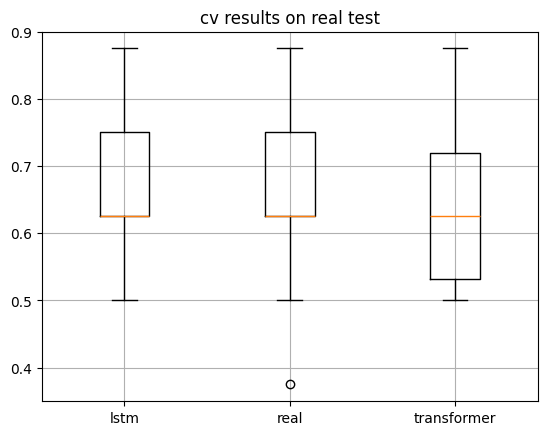

In [112]:
plt.boxplot([eval_metrics_lstm_84[:, 0], eval_metrics_real[:, 0], eval_metrics_trans[:, 0]], labels=['lstm', 'real', 'transformer'])
plt.grid(True)
plt.title('cv results on real test');

In [114]:
np.std(eval_metrics_lstm_84[:, 0]), np.std(eval_metrics_real[:, 0]), np.std(eval_metrics_trans[:, 0]) 

(0.0801950746617272, 0.1025, 0.0951643315533714)